# SVM condensada

-**Integrantes:** Mario Mallea y Maximiliano Ramírez

## Hipótesis de trabajo

El uso de métodos de condensación diseñados para KNN permite filtrar con éxito aquellos puntos que no se transformarán en support vectors durante el entrenamiento de una SVM.

## Metodología

Para efectos del trabajo, se utiliza una implementación del algoritmo de condensación de Hart para KNN (CNN). El objetivo de este método es condensar o reducir la data para quedarse con los vectores que CNN considera relevantes para la clasificación. Una vez obtenidos estos vectores para distintos conjuntos de datos, se realizan comparaciones entre cuantos de los vectores que fueron relevantes resultaron ser support vectors para SVM.

### Liberías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import collections
import random
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.datasets import make_moons
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_iris
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

# Algoritmo de condensación de Hart

Fuente de la implementacion de cnn: 
    https://gist.github.com/jogonba2/04a7f8cbe1237fe47090

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#
#  KNN.py
#  
#  Copyright 2015 Overxflow 
#  

""" Vector difference """
def v_difference(x,y): return [abs(x[i]-y[i]) for i in range(len(x))]

""" Vector difference for weighted euclidean distance """
def v_pond_difference(x,y,w): return [w*abs(x[i]-y[i]) for i in range(len(x))]

""" Returns index of max first element in list inside another list """
def max_distance(l): 
	i,m,mp = 0,float("-inf"),0
	for sl in l:
		if sl[0]>m:
			m  = sl[0]
			mp = i
		i += 1
	return (mp,m)

""" Defines p-distance family """
def p_distance_function(p,x,y,w):
	if p==0:     return max(map(abs,v_difference(x,y)))
	else:    
		if w<=0: return (sum(v_difference(x,y)))**(1.0/p) # If w<=0, distance function isn't a metric.
		else:    return (sum(v_pond_difference(x,y,w)))**(1.0/p)

""" Wilson prototype edition algorithm """
def wilson(prototypes,p,k,w):
	error,new_prototypes = 1,[]
	while error:
		error = 0
		for i in range(len(prototypes)):
			prototype = prototypes[i]
			c         = prototype[1]
			cp = knn(prototypes,p,k,[prototype[0]],w)
			if cp[0][1]==c: new_prototypes.append(prototype)			
			else: error=1; prototypes.remove(prototype); break; # Slowly method :( #
	return prototypes

""" Condensed nearest neighbours algorithm """	

def cnn(prototypes,p,k,w):
	S,G = [prototypes[0]],[] ## S(active set) tiene un punto aleatorio, G vacio
	# First phase #
	for i in range(1,len(prototypes)): ## recorremos todos los ejemplos
		prototype = prototypes[i]
		c         = prototype[1] ## target elemento i
		#print("active set actualizado: ",S)
		cp = knn(S,p,k,[prototype[0]],w) #prediccion de vecino mas cercano de S con cada uno
		#print("Ejemplo",i,"que es",prototype[0], "etiqueta",prototype[1] ,"se clasifico por knn active set como",cp[0][1])
		if cp[0][1]!=c: S.append(prototype) ## target mal clasificado agregalo
		else: G.append(prototype) ## bien clasificados 

	# Second phase #
	#print("active set final primera fase",S)
	#print("segunda fase")

	error = 1
	while G!=[] and error==1: ## termina cuando G esta vacio y error =0 o continua cuando S se añadio una equivocacion se saco de G y vuelve...
		error = 0
		#print("conjunto G", G)
        
		for prototype in G: ## cada uno de los bien clasificados
			#print("active set actualizado: ",S)
			cp = knn(S,p,k,[prototype[0]],w) ## prediccion de cada uno respecto al active set
			#print("ejemplo de G",prototype, "etiqueta", prototype[1],"se clasifico por knn active set como",cp[0][1])
            ## si se equivoco agrego a S y lo quito de G
			if cp[0][1]!=prototype[1]: S.append(prototype); G.remove(prototype); error = 1; break;
	#print("active set final segunda fase",S)
	return S
""" K nearest neighbours algorithm """
def knn(prototypes,p,k,test_samples,w):
	classes = []
	for y in test_samples:
		k_nearest,l= [],0
		for prototype in prototypes:
			c         = prototype[1]
			prototype = prototype[0]
			distance  = p_distance_function(p,prototype,y,w)
			if l<k: k_nearest.append([distance,c])
			else: 
				(pos_max,max_dist) = max_distance(k_nearest)
				if distance<max_dist: 
					k_nearest[pos_max] = [distance,c]
			l += 1
		h = {}
		for nearest in k_nearest:
			if nearest[1] not in h: h[nearest[1]] = 1
			else: h[nearest[1]] += 1
		classes.append([y,max(h,key=h.get)])
	return classes
	

""" Core k nearest neighbours """
def core(prototypes,p,k,test_samples,w,wil,cn):
	# Make Wilson edition #
	if wil==1: prototypes = wilson(prototypes,p,k,w)
	# Make CNN #
	if cn   ==1:
		prototypes = cnn(prototypes,p,k,w)
#		print(prototypes)        
	# Classificate KNN #
	return knn(prototypes,p,k,test_samples,w)
	
""" Stringify output """
def __str__(classified):
	for sample in classified: print ("Class of ",sample[0]," -> ",sample[1])
	
if __name__ == "__main__":
	prototypes    = [([1,2],0),([1,3],0),([2,2],0),([2,3],0),([5,2],1),([5,3],1),([5,4],1),([4,3],1),([4,4],1)] # Train samples #
	test_samples  = [[1,3],[5,2],[25,25],[0,0]] # Test samples #
	__str__(core(prototypes,2,1,test_samples,0,0,1))

Class of  [1, 3]  ->  0
Class of  [5, 2]  ->  1
Class of  [25, 25]  ->  1
Class of  [0, 0]  ->  0


# Primer Data Set

Corresponde a un data set artificial, el cuál es un conjunto de 40 datos y 2 clases linealmente separables.

In [3]:
#Se crea el conjunto

n=40; n_spurious = int(0.2*n);
np.random.seed(11)
X = np.r_[np.random.randn(n, 2) - [2, 2], np.random.randn(n, 2) + [2, 2]]
Y = [-1] * n + [1] * n 

Establecemos el algoritmo de condensación con norma 2 y 1 vecinos más cercanos

In [4]:
## formato de lista de tuplas que requiere la implementación
l=[]
for i in range(X.shape[0]):
    l.append((X[i].tolist(),Y[i]))
#l= [([10,10], 1)]+ l ## agregamos arbitrariamente el primer punto a la lista de puntos
prototypes=l
model= cnn(prototypes,2,1,0)
X = np.array([x[0] for x in prototypes])
Y = [x[1] for x in prototypes]

### Hiperplano generado por SVM

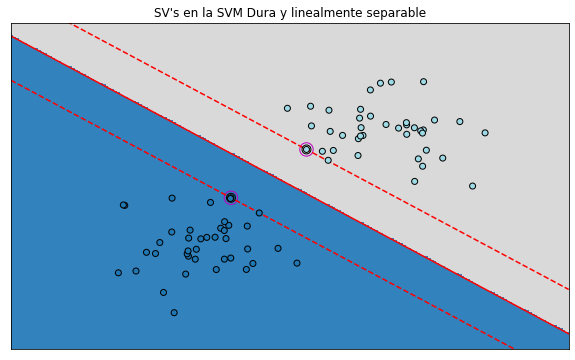

In [5]:
lim_x_y=6 # para verlo de cerca
#lim_x_y=12 # para incluir el punto agregado manualmente

def plot_boundary(clf , ax, t, x_min = -lim_x_y, x_max = lim_x_y, y_min = -lim_x_y, y_max = lim_x_y):

    w = clf.coef_[0]
    b = clf.intercept_[0]
    xx = np.linspace(-6, 6)
    yy = -(w[0]/w[1])*xx - (b/w[1])
    norm_w = np.sqrt(w[0]**2+w[1]**2)
    margin = 1 / norm_w
    cos_alpha = w[1]/norm_w
    margin_y = margin/cos_alpha
    yy_down = yy - margin_y
    yy_up = yy + margin_y
    

    ax.plot(xx, yy, 'k-',color="red")
    ax.plot(xx, yy_down, 'k--',color="red")
    ax.plot(xx, yy_up, 'k--',color="red")

    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80, facecolors='none', zorder=10, edgecolors='k')
    ax.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.tab20,edgecolors='k')

    plt.axis('tight')

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
    Z = Z.reshape(XX.shape)
    
    ax.pcolormesh(XX, YY, Z, cmap=plt.cm.tab20c)
    ax.set_title(t)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    
    return margin, norm_w



fig, ax = plt.subplots(figsize=(10, 6))
clf_1 = SVC(kernel='linear', C=10000)
clf_1.fit(X, Y)
margin,norm_w = plot_boundary(clf_1,ax,t="SV's en la SVM Dura y linealmente separable")
distances = np.multiply(Y,clf_1.decision_function(X))
numeric_tolerance = 0.001
ignored = float(sum(distances<1.0-numeric_tolerance))/float(len(X))
ax.scatter(clf_1.support_vectors_[:,0],clf_1.support_vectors_[:,1], s=180, facecolors='none',edgecolors='m')
plt.show()

In [6]:
##hiperplano
w_1= clf_1.coef_[0]
b_1=clf_1.intercept_[0]
print("w",clf_1.coef_[0],"b",clf_1.intercept_[0])

w [0.56011112 0.61320503] b -0.03165204580242452


## ¿Es sensible CNN al orden de los datos?

Para ilustrar esto, nuestro conjunto será ordenado de 6 formas distintas, para que CNN decida en cada uno cuáles son los vectores relevantes. Se construyen los hiperplanos generados por SVM considerando los vectores entregados por CNN, los cuales corresponden a la gráfica de color negro, y se compara con el hiperplano real, correspondiente a la gráfica roja.

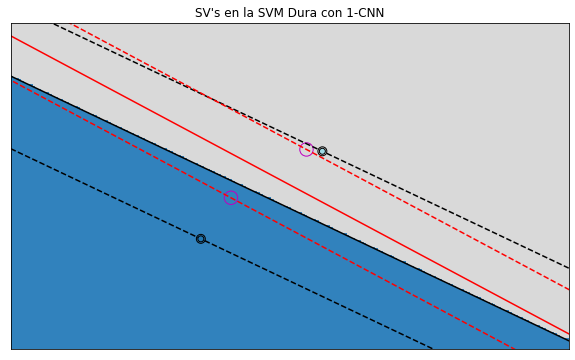

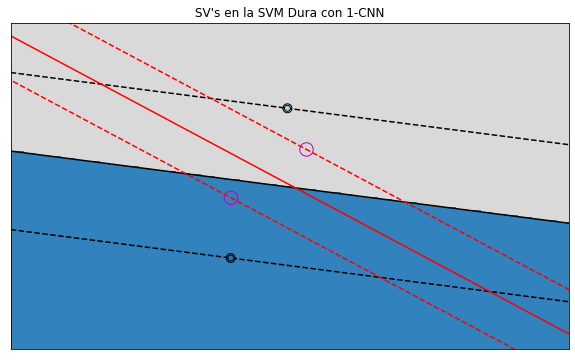

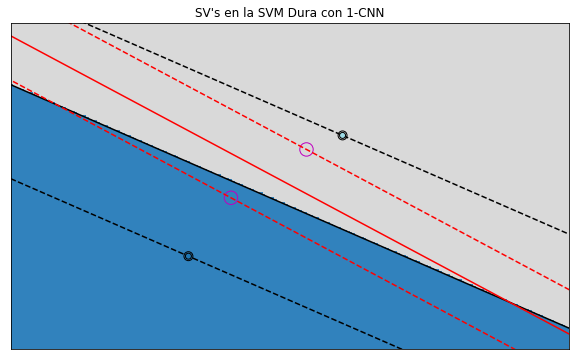

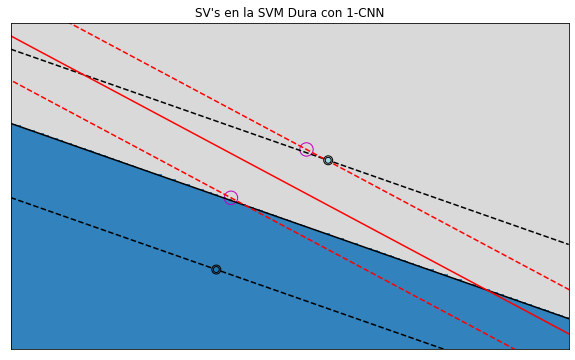

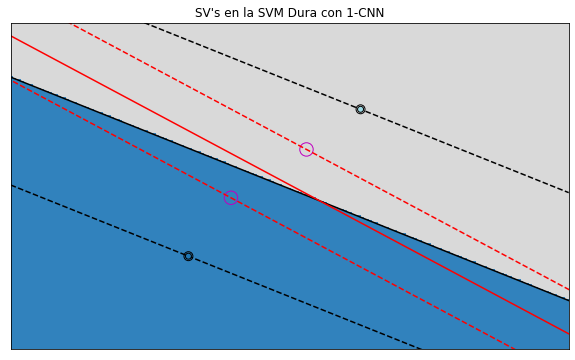

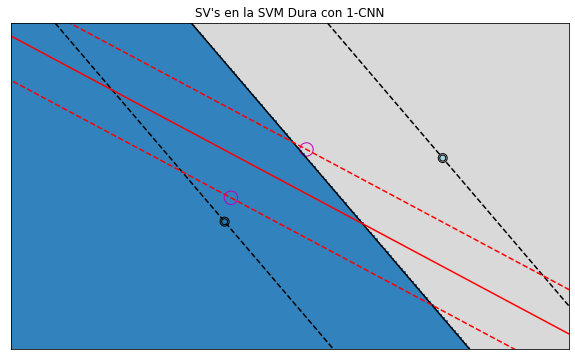

In [7]:
random.seed(1)
lim_x_y=6 # para verlo de cerca
#lim_x_y=12 # para incluir el punto agregado manualmente

def plot_boundary(clf , ax, t, x_min = -lim_x_y, x_max = lim_x_y, y_min = -lim_x_y, y_max = lim_x_y):


    w = clf.coef_[0]
    b = clf.intercept_[0]
    xx = np.linspace(-6, 6)
    yy = -(w[0]/w[1])*xx - (b/w[1])
    norm_w = np.sqrt(w[0]**2+w[1]**2)
    margin = 1 / norm_w
    cos_alpha = w[1]/norm_w
    margin_y = margin/cos_alpha
    yy_down = yy - margin_y
    yy_up = yy + margin_y
    

    ax.plot(xx, yy, 'k-')
    ax.plot(xx, yy_down, 'k--')
    ax.plot(xx, yy_up, 'k--')

    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80, facecolors='none', zorder=10, edgecolors='k')
    ax.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.tab20,edgecolors='k')

    plt.axis('tight')

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
    Z = Z.reshape(XX.shape)
    
    ax.pcolormesh(XX, YY, Z, cmap=plt.cm.tab20c)
    ax.set_title(t)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    ax.set_xticks(())
    ax.set_yticks(())
    
    return margin, norm_w

for j in range(6):
    fig, ax = plt.subplots(figsize=(10, 6))
    desordenado_model=cnn(random.sample(l, len(l)),2,1,0)
    X= np.array([ tupla[0] for tupla in desordenado_model ])
    Y=[ tupla[1] for tupla in desordenado_model ]
    clf = SVC(kernel='linear', C=10000)
    clf.fit(X, Y)
    margin,norm_w = plot_boundary(clf,ax,t="SV's en la SVM Dura con 1-CNN")
    distances = np.multiply(Y,clf.decision_function(X))
    numeric_tolerance = 0.001
    ignored = float(sum(distances<1.0-numeric_tolerance))/float(len(X))
    x = np.linspace(-100000, 10, 100000)


    w = clf_1.coef_[0]
    b = clf_1.intercept_[0]
    xx = np.linspace(-600, 600)
    yy = -(w[0]/w[1])*xx - (b/w[1])
    norm_w = np.sqrt(w[0]**2+w[1]**2)
    margin = 1 / norm_w
    cos_alpha = w[1]/norm_w
    margin_y = margin/cos_alpha
    yy_down = yy - margin_y
    yy_up = yy + margin_y
    ax.plot(xx, yy, 'k-',color="red")
    ax.plot(xx, yy_down, 'k--',color="red")
    ax.plot(xx, yy_up, 'k--',color="red")

    ax.scatter(clf_1.support_vectors_[:,0],clf_1.support_vectors_[:,1], s=180, facecolors='none',edgecolors='m')
    
plt.show()

**Podemos notar que la cantidad de support vectors para SVM son 2, lo cuál CNN acierta en este caso, pues considera que 2 son los vectores relevantes, logrando filtrar una gran parte de los datos que no se convertirán en support vectors con éxito, sin embargo, como se aprecia en las figuras, las elecciones de candidatos a support vectors entregadas por CNN en ciertas situaciones inducen hiperplanos muy errados con respecto al real**

## Segundo Data Set (Make Moon)

Este es un conjunto de datos no linealmente separables. Para abordar este problema, se aplica CNN al conjunto de datos, con el fin de que el algoritmo entregue los vectores que considera relevantes, es decir, candidatos a support vectors. Para posteriormente construir una frontera de decisión para SVM con margenes suaves y kernel gaussiano.


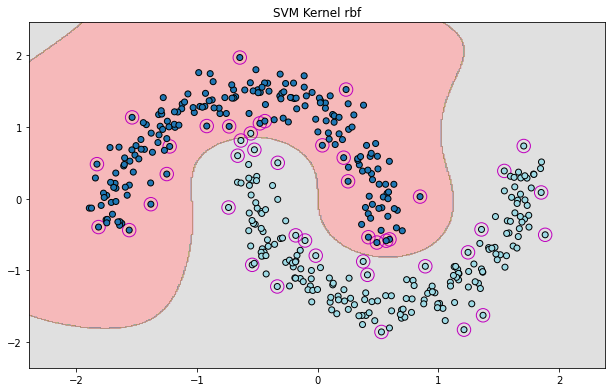

In [8]:
X,Y = make_moons(n_samples=400, noise=0.1, random_state=0)
scaler = StandardScaler()
X = scaler.fit_transform(X)
for i in range(Y.shape[0]):
    if Y[i]==0:
        Y[i]=-1
        

C_default=1
clf_1 = svm.SVC(kernel='rbf', gamma=2, C=C_default)
#clf = svm.SVC(kernel='poly', degree=5, C=C_default)
#clf = svm.SVC(kernel='poly', degree=3, gamma=0.5, coef0=0.25, C=1)
#clf = svm.SVC(kernel='sigmoid', C=1, gamma=0.1, coef0=0.25)
#clf = svm.SVC(kernel='poly', C=1000, degree=5)

#k(x_1,x_2) =( x_1^Tx_2 + constant)**p

clf_1.fit(X, Y)
svectors= clf_1.support_vectors_

h=.01
X0, X1 = X[:, 0], X[:, 1]
x_min, x_max = X0.min() - .5, X0.max() + .5
y_min, y_max = X1.min() - .5, X1.max() + .5
xx_1, yy_1 = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))


Z_1 = clf_1.predict(np.c_[xx_1.ravel(), yy_1.ravel()])
Z_1 = Z_1.reshape(xx_1.shape)
f = plt.figure(1, figsize=(10, 6))
plt.clf()
ax = f.add_axes([0.1, 0.1, 0.8, 0.8])
out_original = ax.contourf(xx_1, yy_1, Z_1, cmap=plt.cm.Set1, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.tab20, edgecolors='k')
ax.scatter(clf_1.support_vectors_[:,0],clf_1.support_vectors_[:,1], s=180, facecolors='none',edgecolors='m')
plt.title("SVM Kernel rbf")
plt.show()


In [9]:
svectors.shape #Cantidad de support vectors para SVM con kernel gaussiano

(44, 2)

## ¿Es también este caso sensible al orden de los datos?

Al igual que en el caso anterior, se comparan cuantos puntos relevantes para CNN fueron support vectors para SVM.

In [10]:
random.seed(1)
l= []

for i in range(X.shape[0]):
    l.append((X[i].tolist(),Y[i]))

#
for j in range(6):
    desordenado_model=cnn(random.sample(l, len(l)),2,1,0)
    X_cnn= np.array([ tupla[0] for tupla in desordenado_model ])
    Y_cnn=[ tupla[1] for tupla in desordenado_model ]
    
    print("El numero de relevantes en el desorden: ", j+1, "fueron: ", X_cnn.shape[0])
    
    maxi=0
    
    for sv in X_cnn:
        for i in range(svectors.shape[0]):
            if (sv == svectors[i]).all():
                maxi+=1
    print("cnn encontró: ",maxi, "support vectors")
    print("El total de puntos es: ", X.shape[0])
    print("Los puntos filtrados por CNN fueron: ", X.shape[0]-X_cnn.shape[0])
    print("::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::: \n")

El numero de relevantes en el desorden:  1 fueron:  12
cnn encontró:  4 support vectors
El total de puntos es:  400
Los puntos filtrados por CNN fueron:  388
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::: 

El numero de relevantes en el desorden:  2 fueron:  12
cnn encontró:  4 support vectors
El total de puntos es:  400
Los puntos filtrados por CNN fueron:  388
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::: 

El numero de relevantes en el desorden:  3 fueron:  13
cnn encontró:  6 support vectors
El total de puntos es:  400
Los puntos filtrados por CNN fueron:  387
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::: 

El numero de relevantes en el desorden:  4 fueron:  14
cnn encontró:  7 support vectors
El total de puntos es:  400
Los puntos filtrados por CNN fueron:  386
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::: 

El numero de relevantes en el desorden:  5 fueron:  14
cnn encontró:  6 support vectors
El total de puntos es:  

**De los 44 support vectors entregados por SVM, CNN considera del total de datos que en promedio 13 son relevantes, de los cuales en promedio 5 coinciden con ser support vectors, es decir, CNN logra encontrar solamente el 11% de los support vectors para este problema, puede ser esta la razón de que se obtengan malas fronteras de decisión.**

### Comparación de fronteras de decisión

 se generan las distintas fronteras de decisión construidas por SVM de margen suave y kernel Gaussiano, sólamente considerando los candidatos a support vectors entregados por CNN.

Se compara la frontera de decisión real, correspondiente a la figura de arriba, marcada de color rojo, con las fronteras generadas por CNN a través de los distintos ordenes del conjunto de datos, las cuales corresponden a la fronteras de color azul.

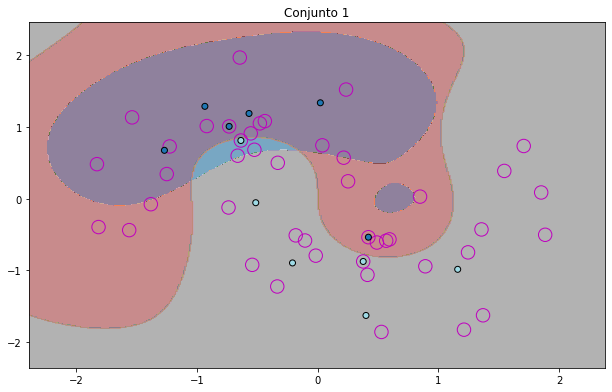

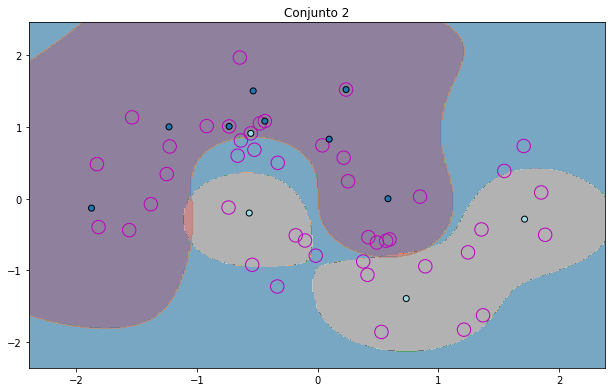

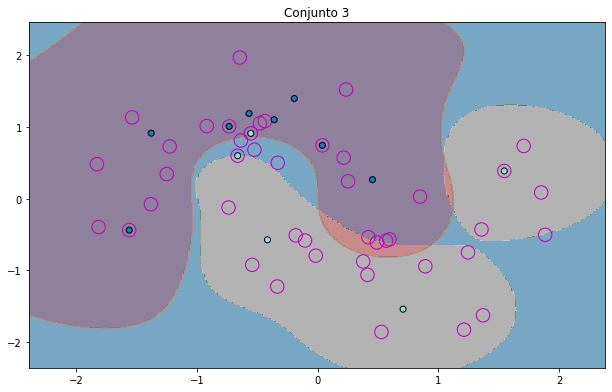

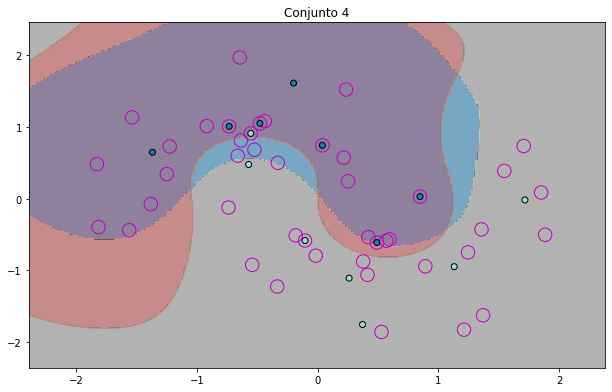

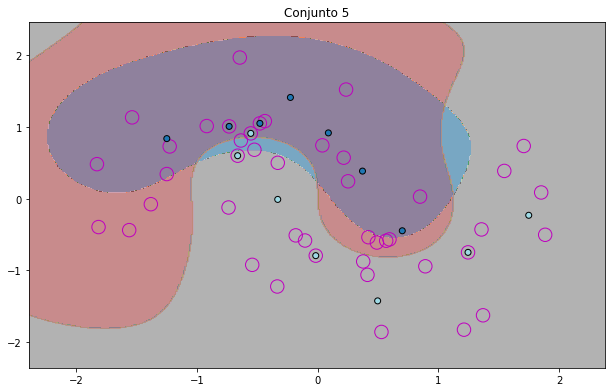

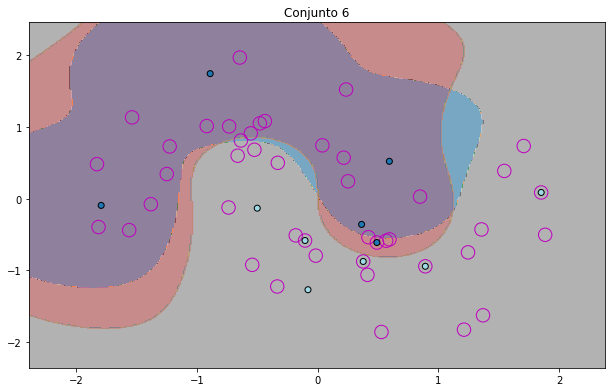

In [11]:
random.seed(1)
l=[]
for i in range(X.shape[0]):
    l.append((X[i].tolist(),Y[i]))

    
#Se generan los 6 conjuntos con distintos ordenes
for j in range(6):
    desordenado_model=cnn(random.sample(l, len(l)),2,1,0)
    X= np.array([ tupla[0] for tupla in desordenado_model ])
    Y=[ tupla[1] for tupla in desordenado_model ]


    clf = svm.SVC(kernel='rbf', gamma=2, C=C_default)
    #clf = svm.SVC(kernel='poly', degree=5, C=C_default)
    #clf = svm.SVC(kernel='poly', degree=3, gamma=0.5, coef0=0.25, C=1)
    #clf = svm.SVC(kernel='sigmoid', C=1, gamma=0.1, coef0=0.25)
    #clf = svm.SVC(kernel='poly', C=1000, degree=5)

    #k(x_1,x_2) =( x_1^Tx_2 + constant)**p

    clf.fit(X, Y)

    h=.01

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))


    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    f = plt.figure(1, figsize=(10, 6))
    plt.clf()
    ax = f.add_axes([0.1, 0.1, 0.8, 0.8])
    out = ax.contourf(xx, yy, Z, cmap=plt.cm.tab20c, alpha=1)
    out_2 = ax.contourf(xx_1, yy_1, Z_1, cmap=plt.cm.Set1, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.tab20, edgecolors='k')
    ax.scatter(clf_1.support_vectors_[:,0],clf_1.support_vectors_[:,1], s=180, facecolors='none',edgecolors='m')
    stri = 'Conjunto ' + str(j+1)
    
    plt.title(stri)
    plt.show()

# Tercer Data Set (Breast Cancer)

Correspondiente a un conjunto de datos reales linealmente separables en sus 30 dimensiones, el cuál cuenta con 569 observaciones, 30 atributos y 2 clases.

In [12]:
data = load_breast_cancer()

X = data.data #569x30 matrix
y = data.target #array of 569 entries (class id)

classes = np.unique(y)

print(X.shape,y.shape) 
print(data.target_names) #class names
print(classes) #class codes


(569, 30) (569,)
['malignant' 'benign']
[0 1]


**Pre-procesamiento**

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
svm = SVC(kernel='linear', C=10000)

print(X_train_scaled.shape,y_train.shape)
svm.fit(X_train_scaled,y_train)

svectors= svm.support_vectors_

(398, 30) (398,)


In [15]:
svectors.shape #Se obtuvieron 24 support vectors para un conjunto de entrenamiento de 398

(24, 30)

In [16]:
from sklearn.svm import SVC

random.seed(1)
l= []
for i in range(X_train_scaled.shape[0]):
    l.append((X_train_scaled[i].tolist(),y_train[i]))
    
for j in range(6):
    desordenado_model=cnn(random.sample(l, len(l)),2,1,0)
    X_cnn= np.array([ tupla[0] for tupla in desordenado_model ])
    Y_cnn=[ tupla[1] for tupla in desordenado_model ]
    
    print("El numero de relevantes en el desorden: ", j, "fueron: ", X_cnn.shape[0])
    
    maxi=0
    
    for sv in X_cnn:
        for i in range(svectors.shape[0]):
            if (sv == svectors[i]).all():
                maxi+=1
    print("cnn encontró: ",maxi, "support vectors")
    print("El total de puntos es: ", X.shape[0])
    print("Los puntos filtrados por CNN fueron: ", X.shape[0]-X_cnn.shape[0])
    print("::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::: \n")
        

El numero de relevantes en el desorden:  0 fueron:  62
cnn encontró:  11 support vectors
El total de puntos es:  569
Los puntos filtrados por CNN fueron:  507
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::: 

El numero de relevantes en el desorden:  1 fueron:  59
cnn encontró:  11 support vectors
El total de puntos es:  569
Los puntos filtrados por CNN fueron:  510
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::: 

El numero de relevantes en el desorden:  2 fueron:  53
cnn encontró:  8 support vectors
El total de puntos es:  569
Los puntos filtrados por CNN fueron:  516
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::: 

El numero de relevantes en el desorden:  3 fueron:  54
cnn encontró:  9 support vectors
El total de puntos es:  569
Los puntos filtrados por CNN fueron:  515
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::: 

El numero de relevantes en el desorden:  4 fueron:  55
cnn encontró:  7 support vectors
El total de puntos es:

Se obtiene como resultado que CNN considera en promedio 56 vectores relevantes y de estos en promedio 38% (11) resultan ser support vectors (total: 24 sv)

## Cuarto Data Set

Se utiliza el data set Weather AUS, el cuál es un conjunto de datos reales, con 56.420 observaciones no nulas, 17 atributos y 2 clases.

La idea de este dataset, es verificar si es factible utilizar CNN para conjuntos con cantidades relativamente grandes de datos. Obteniendo como resultado, que no es posible ejecutar CNN para un tiempo prudente en este conjunto de datos, a pesar de que si es posible ejecutar SVM, esto es un punto en contra de CNN.

La dimensión del problema (56420, 17), no permite la ejecución del algoritmo cnn.

In [17]:
x_train=pd.read_csv("weatherAUS.csv") #Los datos se encuentran en el repositorio

In [18]:
x_train = x_train.dropna()
x_train

y_train = x_train['RainTomorrow']

for i in range(y_train.shape[0]):
    if y_train.iloc[i]== 'No':
        y_train.iloc[i]= 0
        
    else:
        y_train.iloc[i]= 1

In [19]:
x_train.shape

(56420, 24)

In [20]:
numeric_features = list(x_train.dtypes[x_train.dtypes != "object"].index) #columnas numericas
numericas=x_train.loc[:,numeric_features] #sus datos
numericas= pd.DataFrame(data=numericas, columns= numeric_features)


In [21]:
y_train = y_train.astype(int)

In [22]:
svm = SVC(kernel='linear', C=10000)

svm.fit(numericas,y_train)

svectors= svm.support_vectors_

In [23]:
svectors.shape

(109, 17)

In [24]:
#Esto no correrá en un tiempo prudente

random.seed(1)
l= []

numericas = numericas.values
y_train = y_train.values

for i in range(numericas.shape[0]):
    l.append((numericas[i].tolist(),y_train[i]))
    
for j in range(6):
    desordenado_model=cnn(random.sample(l, len(l)),2,1,0)
    X_cnn= np.array([ tupla[0] for tupla in desordenado_model ])
    Y_cnn=[ tupla[1] for tupla in desordenado_model ]
    
    print("El numero de relevantes en el desorden: ", j, "fueron: ", X_cnn.shape[0])
    
    maxi=0
    
    for sv in X_cnn:
        for i in range(svectors.shape[0]):
            if (sv == svectors[i]).all():
                maxi+=1
    print("cnn encontró: ",maxi, "support vectors")
    print("El total de puntos es: ", X.shape[0])
    print("Los puntos filtrados por CNN fueron: ", X.shape[0]-X_cnn.shape[0])
    print("::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::: \n")

        

KeyboardInterrupt: 

# Quinto Data Set (Iris)

El cuál corresponde a un conjunto de datos reales, que consta de 150 observaciones, 4 atributos y 3 clases, sin embargo, para efectos de este experimento sólo se consideran 2.

In [25]:
dat = load_iris()

X = dat.data #150x4 matrix
y = dat.target #array of 150 entries (class id)

classes = np.unique(y)

print(X.shape,y.shape) 
print(dat.target_names) #class names
print(classes) #class codes

(150, 4) (150,)
['setosa' 'versicolor' 'virginica']
[0 1 2]


In [26]:
df = pd.concat((pd.DataFrame(X),pd.DataFrame(y, columns= ['clase'])), axis=1)

In [27]:
df= df[df['clase'] != 2]

In [28]:
X_train =df.drop(['clase'],axis=1)
y_train = df['clase']

In [29]:
svm = SVC(kernel='linear', C=10000)

svm.fit(X_train, y_train)

svectors= svm.support_vectors_

In [30]:
svectors.shape

(3, 4)

In [31]:
random.seed(1)
l= []


for i in range(X_train.shape[0]):
    l.append((X_train.values[i].tolist(),y_train.values[i]))
    
for j in range(6):
    desordenado_model=cnn(random.sample(l, len(l)),2,1,0)
    X_cnn= np.array([ tupla[0] for tupla in desordenado_model ])
    Y_cnn=[ tupla[1] for tupla in desordenado_model ]
    
    print("El numero de relevantes en el desorden: ", j, "fueron: ", X_cnn.shape[0])
    
    maxi=0
    
    for sv in X_cnn:
        for i in range(svectors.shape[0]):
            if (sv == svectors[i]).all():
                maxi+=1
    print("cnn encontró: ",maxi, "support vectors")
    print("El total de puntos es: ", X.shape[0])
    print("Los puntos filtrados por CNN fueron: ", X.shape[0]-X_cnn.shape[0])
    print("::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::: \n")
        

El numero de relevantes en el desorden:  0 fueron:  3
cnn encontró:  1 support vectors
El total de puntos es:  150
Los puntos filtrados por CNN fueron:  147
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::: 

El numero de relevantes en el desorden:  1 fueron:  2
cnn encontró:  0 support vectors
El total de puntos es:  150
Los puntos filtrados por CNN fueron:  148
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::: 

El numero de relevantes en el desorden:  2 fueron:  3
cnn encontró:  0 support vectors
El total de puntos es:  150
Los puntos filtrados por CNN fueron:  147
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::: 

El numero de relevantes en el desorden:  3 fueron:  2
cnn encontró:  0 support vectors
El total de puntos es:  150
Los puntos filtrados por CNN fueron:  148
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::: 

El numero de relevantes en el desorden:  4 fueron:  2
cnn encontró:  0 support vectors
El total de puntos es:  150
L

Del total de support vectors para SVM (4), tenemos que CNN en promedio considera 2 relevantes, obteniendo que en promedio ninguno de estos resultan ser support vectors

# Conclusión

Con este trabajo de investigación determinamos que el algoritmo de condensación para KNN (CNN), no logran obtener correctamente los support vectors, además se evidencia la sensibilidad que tiene el algoritmo al orden en que se encuentre el conjunto de datos, y su alta complejidad computacional consecuencia de ejecutar KNN iterativamente, hace inviable la ejecución del algoritmo en conjuntos de datos grandes. Por otro lado, el algoritmo de SVM, puede ser considerado como uno de reducción de información, ya que, la clasificación queda determinada únicamente por los support vectors$^1$, pero para obtener estos, se debe contar con toda la información

$^1$ Correspondiente a todos los vectores con coeficiente $\alpha \neq 0$ en el problema dual.

# Pregunta abierta

Como se menciona anteriormente, los support vectors corresponden a los vectores con coeficiente $\alpha \neq 0$ en el problema dual. Lo que nos lleva a pensar, dado que CNN no es factible para la reducción de información.

¿Existirá alguna forma de aprender los multiplicadores no nulos a partir únicamente de los datos, sin hacer SVM?